In [3]:
import xgboost as xgb
import pandas as pd

In [10]:
meta = pd.read_pickle("all_meta_mutect.pkl", compression='bz2')

In [11]:
import numpy as np 
caller = ['mutect',]
add_caller = ['muse',]
meta['label'] = np.zeros(len(meta.index))

add_caller_index = [i for i in range(len(meta.columns)) if len(list(meta.columns)[i]) == (len(caller)+len(add_caller)) and  list(meta.columns)[i][len(caller)] == add_caller[0]]

#print(meta, add_caller_index)
    
label = np.array(meta[list(meta.columns)[add_caller_index[0]]]) - np.array(meta[list(meta.columns)[1]])
label = (label > 0).astype(int)
meta['label'] = label
    
    
rand_split = np.random.rand(len(meta))
train_list = rand_split < 0.8
test_list = rand_split >= 0.8

data_train = meta[train_list]
data_test = meta[test_list]
    
train_labels = np.array(data_train['label'], dtype='f')
test_labels = np.array(data_test['label'], dtype='f')
    
drop = [i for i in meta.columns if i[0] == caller[0]]
drop.append('label')

train_features = np.array(data_train.drop(columns = drop), dtype='f')
test_features = np.array(data_test.drop(columns = drop), dtype='f')

In [12]:
from sklearn.metrics import accuracy_score
model = xgb.XGBClassifier()
model.fit(train_features, train_labels)
# make predictions for test data
y_pred = model.predict(test_features)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.24%


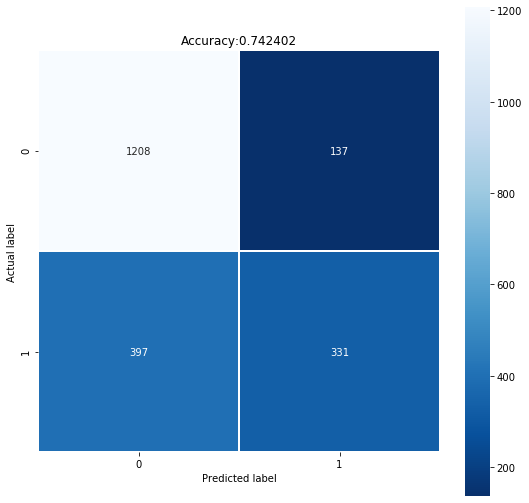

In [16]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
cm = metrics.confusion_matrix(test_labels, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
    
plt.xlabel('Predicted label')
plt.title("Accuracy:%f" % accuracy)
    #plt.yticks((0.5,1.5),('zero', 'not zero'))
    #plt.xticks((0.5,1.5),('zero', 'not zero'))
plt.show()

In [17]:
from comb import my_combos
possible_callers = ['muse', 'mutect', 'somaticsniper', 'varscan']
index = ['muse', 'mutect', 'somaticsniper', 'varscan']
two_combos = my_combos(possible_callers, 2)
index.extend(two_combos)

index = ['muse', 'mutect', 'somaticsniper', 'varscan', ['muse', 'mutect'], ['muse', 'varscan'], ['somaticsniper', 'varscan'], 
         ['somaticsniper', 'muse'], ['somaticsniper', 'mutect'], ['varscan', 'mutect']]
print(index)

['muse', 'mutect', 'somaticsniper', 'varscan', ['muse', 'mutect'], ['muse', 'varscan'], ['somaticsniper', 'varscan'], ['somaticsniper', 'muse'], ['somaticsniper', 'mutect'], ['varscan', 'mutect']]


In [55]:
from sklearn.metrics import r2_score

def regression():
    
    for c in possible_callers:
        for caller in possible_callers:
            if caller != c:
                print(c, caller)
                
                meta = pd.read_pickle("all_meta_{}.pkl".format(c), compression='bz2')
                
                meta['label'] = np.zeros(len(meta.index))

    
                label = np.array(meta[(c, caller)]) - np.array(meta[(c,)])
                meta['label'] = label
    
    
                rand_split = np.random.rand(len(meta))
                train_list = rand_split < 0.8
                test_list = rand_split >= 0.8

                data_train = meta[train_list]
                data_test = meta[test_list]
    
                train_labels = np.array(data_train['label'], dtype='f')
                test_labels = np.array(data_test['label'], dtype='f')
    
                drop = [i for i in meta.columns if i[0] == c]
                drop.append('label')

                train_features = np.array(data_train.drop(columns = drop), dtype='f')
                test_features = np.array(data_test.drop(columns = drop), dtype='f')
        
                model = xgb.XGBRegressor()
                model.fit(train_features, train_labels)
                # make predictions for test data
                y_pred = model.predict(test_features)
                predictions = [round(value) for value in y_pred]
                # evaluate predictions
                print(r2_score(predictions, test_labels))

                correct = 0
                greater = []
                less = []
                print(len(test_labels))

                for i in range(len(test_labels)):

                    if predictions[i] == test_labels[i]:
                        correct += 1
                    if predictions[i] > test_labels[i]:
                        greater.append(predictions[i] - test_labels[i])
                    if predictions[i] < test_labels[i]:
                        less.append(predictions[i] - test_labels[i])
                
                print("prediction greater", len(greater)/ len(test_labels), np.mean(greater))
                print("prediction less", len(less)/ len(test_labels), np.mean(less))
                print("correct percentage", correct / len(test_labels))

        print()
      
    
    for i in range(4,len(index)):
        for c in possible_callers:
            if c not in index[i]:
                print(index[i], c)

                meta = pd.read_pickle("all_meta_{}_{}.pkl".format(index[i][0], index[i][1]), compression='bz2')
                
                meta['label'] = np.zeros(len(meta.index))

                
                label = np.array(meta[(index[i][0], index[i][1], c)]) - np.array(meta[(index[i][0],index[i][1])])
                meta['label'] = label
    
    
                rand_split = np.random.rand(len(meta))
                train_list = rand_split < 0.8
                test_list = rand_split >= 0.8

                data_train = meta[train_list]
                data_test = meta[test_list]
    
                train_labels = np.array(data_train['label'], dtype='f')
                test_labels = np.array(data_test['label'], dtype='f')

                drop = [j for j in meta.columns if j[0] == index[i][0]]
                drop.append('label')

                train_features = np.array(data_train.drop(columns = drop), dtype='f')
                test_features = np.array(data_test.drop(columns = drop), dtype='f')
        
                model = xgb.XGBRegressor(max_depth=6, learning_rate=0.01, n_estimators=1000, verbosity=1, 
                                         silent=None, objective='reg:squarederror', booster='gbtree',
                                         n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
                                         max_delta_step=0, subsample=1, colsample_bytree=1, 
                                         colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, 
                                         reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, 
                                         seed=None, missing=None, importance_type='gain')
                model.fit(train_features, train_labels)
                # make predictions for test data
                y_pred = model.predict(test_features)
                predictions = [round(value) for value in y_pred]
                # evaluate predictions
                print(r2_score(predictions, test_labels))

                correct = 0
                greater = []
                less = []
                print(len(test_labels))

                for j in range(len(test_labels)):

                    if predictions[j] == test_labels[j]:
                        correct += 1
                    if predictions[j] > test_labels[j]:
                        greater.append(predictions[j] - test_labels[j])
                    if predictions[j] < test_labels[j]:
                        less.append(predictions[j] - test_labels[j])
                
                print("prediction greater", len(greater)/ len(test_labels), np.mean(greater))
                print("prediction less", len(less)/ len(test_labels), np.mean(less))
                print("correct percentage", correct / len(test_labels))
        print()
                
regression()

muse mutect
[18:17:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.460694974213921
1937
prediction greater 0.4527620030975736 1.336374
prediction less 0.23593185338151781 -2.643326
correct percentage 0.31130614352090863
muse somaticsniper
[18:17:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.2629165653496276
2012
prediction greater 0.0889662027833002 1.2011173
prediction less 0.20178926441351888 -1.4384236
correct percentage 0.7092445328031809
muse varscan
[18:17:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.6287641086140392
1913
prediction greater 0.4537375849451124 1.420507
prediction less 0.2435964453737585 -2.4356222
correct percentage 0.30266596968112913

mutect muse
[18:17:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.446526774